In [2]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

    86% |███████████████████████████▌    | 509.9MB 47.6MB/s eta 0:00:02

    100% |████████████████████████████████| 592.3MB 48.3MB/s 


In [3]:
!pip3 install torchvision

    100% |████████████████████████████████| 51kB 1.7MB/s 
    100% |████████████████████████████████| 2.0MB 520kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving protein_amino_acid_mapping.txt to protein_amino_acid_mapping.txt
Saving train_file.txt to train_file.txt
User uploaded file "protein_amino_acid_mapping.txt" with length 25601 bytes
User uploaded file "train_file.txt" with length 436 bytes


In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import random
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class Config():
  train_batch_size = 32
  train_number_epochs = 2
  learning_rate = .0005

In [0]:
char_to_index = {'M': 0, 'S': 1, 'V': 2, 'E': 3, 'D': 4, 'F': 5, 'I': 6, 'Q': 7, 'P': 8, 'Y': 9, 'T': 10, 'L': 11, 'N': 12, 'R': 13, 'G': 14, 'K': 15, 'C': 16, 'H': 17, 'A': 18, 'W': 19, 'U': 20}
index_to_char = {0: 'M', 1: 'S', 2: 'V', 3: 'E', 4: 'D', 5: 'F', 6: 'I', 7: 'Q', 8: 'P', 9: 'Y', 10: 'T', 11: 'L', 12: 'N', 13: 'R', 14: 'G', 15: 'K', 16: 'C', 17: 'H', 18: 'A', 19: 'W', 20: 'U'}
n_letters = len(char_to_index)

In [0]:
#https://colab.research.google.com/notebook#fileId=/v2/external/notebooks/io.ipynb&scrollTo=p2E4EKhCWEC5
#https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb - double backpropogation
#batching with sequence data 

In [0]:
def letterToIndex(letter):
  return char_to_index[letter]

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def aminoAcidstoTensor(aminoAcidSeq):
  tensor = torch.zeros(1, n_letters, len(aminoAcidSeq)) #torch.zeros(len(aminoAcidSeq), 1, n_letters)
  for idx, letter in enumerate(aminoAcidSeq):
    tensor[0][letterToIndex(letter)][idx] = 1
  return tensor   
  

In [0]:
categories = [0, 1]
proteins = {}
training_data = []


In [0]:
with open("protein_amino_acid_mapping.txt") as protein_data:
  for line in protein_data:
    line = line.strip('\n')
    name_seq_pair = line.split(' ')
    proteins[name_seq_pair[0]] = name_seq_pair[1]
                                         
protein_data.close()

with open('train_file.txt') as train_data:
  for line in train_data:
    line = line.strip('\n')
    training_data.append(line)
    
train_data.close()

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_size = 1
        self.num_layers = 1

        #torch.nn.functional.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) → Tensor
        filters = torch.randn(8,4,3,3)
        inputs = torch.randn(1,4,5,5)
        
        #Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv = nn.Conv2d(1, 12, (21, 1))
        
        #LSTM(self.hidden_size, self.hidden_size, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(12, self.hidden_size, bidirectional=True)
        
        # Linear(in_features, out_features (num classes))
        self.fc = nn.Linear(self.hidden_size * 2, 2)


    def forward_once(self, x):
        #input: batch size x Cin x Height x Width  i.e. [1, 1, 21, 325]
        
        h0 = Variable(torch.zeros(self.num_layers * 2, self.hidden_size))  # 2 for bidirection
        c0 = Variable(torch.zeros(self.num_layers * 2, self.hidden_size))
        
        seq_len = x.size()[3]
        self.conv.kernel_size = (seq_len, 21)
        x = self.conv(x)
        x = F.max_pool2d(F.relu(x), (1, 6))    #output: 1xoutchannelx1xsize_due_to_conv
        x = torch.squeeze(x, 2)                #output: 1xoutchannelxsize_due_to_convolution
        x = x.permute(2, 0, 1)                 #output: conv_size x 1 x out_channels
    
        #input expected: (seq_len, batch, input_size)  batch first: (batch, seq, feature)
        out, (h_n, c_n) = self.lstm(x, (h0, c0)) #output (seq_len, batch, hidden_size * num_directions)
        #output (seq_len (conv_size), batch, hidden_size * num_directions) ie 54, 1, 2
        out = self.fc(out[-1, :, :])
       
        return out


    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

In [0]:
def getProteinPair(index):
  sample = training_data[index]
  pair_label = sample.split(' ')
  protein_pair = pair_label[0].split('-')
  protein_name_1 = protein_pair[0]
  protein_name_2 = protein_pair[1]
  label = pair_label[1]
  
  protein_seq_1 = proteins[protein_name_1]
  protein_seq_2 = proteins[protein_name_2]
    
  #Variable(aminoAcidstoTensor(protein_seq_1)).cuda()
  
  protein_1_tensor = Variable(aminoAcidstoTensor(protein_seq_1))
  #get seq_length x 1 x  21
  protein_2_tensor = Variable(aminoAcidstoTensor(protein_seq_2))

  label_tensor = Variable(torch.LongTensor([categories.index(0)]))
  return protein_1_tensor, protein_2_tensor, label_tensor


In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        label = label.type(torch.FloatTensor)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
       
        return loss_contrastive

[3.9201288018375635e-05, 4.7073200448721764e-07, 8.263603376690298e-06, 0.0001044461241690442, 2.0440895241335966e-05, 9.632229875933263e-07]


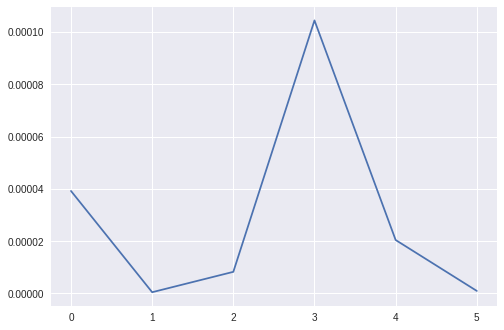

In [176]:
counter = []
loss_history = []
iteration_number = 0

#net.conv1.register_forward_hook(printnorm)
#net.conv1.register_backward_hook(printgradnorm)

net = Net()


#get protein of dimensions: batch x height(21) x seq_length
for epoch in range(1):
  for i in range(0, 6):
    counter.append(i)
    protein1, protein2, label = getProteinPair(i)
    protein1 = protein1.unsqueeze(0)  #add a dimension for c_in
    protein2 = protein2.unsqueeze(0)
    output1, output2 = net(protein1, protein2)
    #output: size_conv x 2 

    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(), Config.learning_rate)

    optimizer.zero_grad()
    contrastive_loss = criterion(output1, output2, label)
    contrastive_loss.backward()
    optimizer.step()
    loss_history.append(contrastive_loss.data[0])

print(loss_history)
plt.plot(counter,loss_history)
plt.show()

In [0]:
test = Variable(torch.rand(1, 2))
print(test)
print(1 - test)

In [0]:
input_size = 20
hidden_size = 50
output_size = 7
batch_size = 1
n_layers = 2
seq_len = 15

inputs = Variable(torch.rand(seq_len, batch_size, input_size, hidden_size))
print(inputs.size())

x = torch.squeeze(inputs, 1)
print(x.size())
x = x.permute(0, 2, 1)
print(x.size())
x = x.long()
print(x.dtype)



In [0]:
counter = []
loss_history = []
iteration_number = 0

#for epoch in range(Config.train_number_epochs):
#    for i, data in enumerate(train_dataloader):
        protein1, protein2, label = data
        output1, output2 = net(protein1, protein2)
        optimizer.zero_grad()
        contrastive_loss = criterion(output1, output2, label)
        contrastive_loss.backward()
        optimizer.step()


In [0]:
class Net_Test(nn.Module):
    def __init__(self):
        super(Net_Test, self).__init__()
        #could also pass in num_layers, but assume 1 in this case
        #inchannels=input height, outchannels=number filters, kernel size= filter size
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.pool1 = nn.MaxPool1d(2, 2)
        


    def forward(self, x):
        print("before dim", x.dim())
        x = F.relu(self.conv1(x))
        print("after dim", x.dim())
        return x



In [0]:
net = Net_Test()
print(net)

net.conv1.register_forward_hook(printnorm)
net.conv1.register_backward_hook(printgradnorm)

input = Variable(torch.randn(1, 32, 32))
out = net(input)
print(out)